## Generation of the map band limited

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import camb

In [2]:
def generate_power_spectra_CAMB(Nside,  r=10**(-2), Alens=1, H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06, ns=0.965, lens_potential_accuracy=1, nt=0, ntrun=0, type_power='total', typeless_bool=False):
    """
    Return [Cl^TT, Cl^EE, Cl^BB, Cl^TE]
    """
    lmax = 2*Nside
    # pars = camb.CAMBparams(max_l_tensor=lmax, parameterization='tensor_param_indeptilt')
    pars = camb.CAMBparams(max_l_tensor=lmax)
    pars.WantTensors = True

    pars.Accuracy.AccurateBB = True
    pars.Accuracy.AccuratePolarization = True
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=omk, tau=tau, Alens=Alens)
    pars.InitPower.set_params(As=2e-9, ns=ns, r=r, parameterization='tensor_param_indeptilt', nt=nt, ntrun=ntrun)
    pars.max_eta_k_tensor = lmax + 100  # 15000  # 100

    # pars.set_cosmology(H0=H0)
    pars.set_for_lmax(lmax, lens_potential_accuracy=lens_potential_accuracy)

    print("Calculating spectra from CAMB !")
    results = camb.get_results(pars)

    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True, lmax=lmax)    
    if typeless_bool:
        return powers
    return powers[type_power]

In [3]:
nside = 512
camb_cls = generate_power_spectra_CAMB(nside)

Calculating spectra from CAMB !


In [4]:
maps_TQU = hp.synfast(camb_cls.T,nside, new=True)

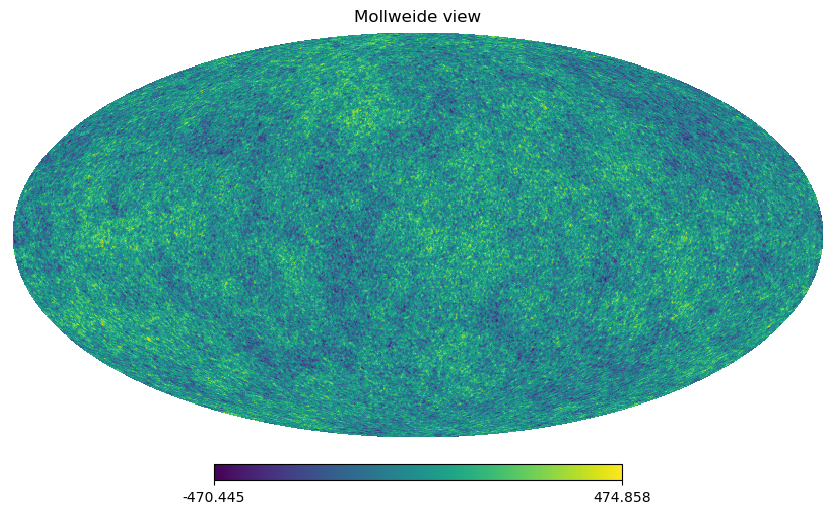

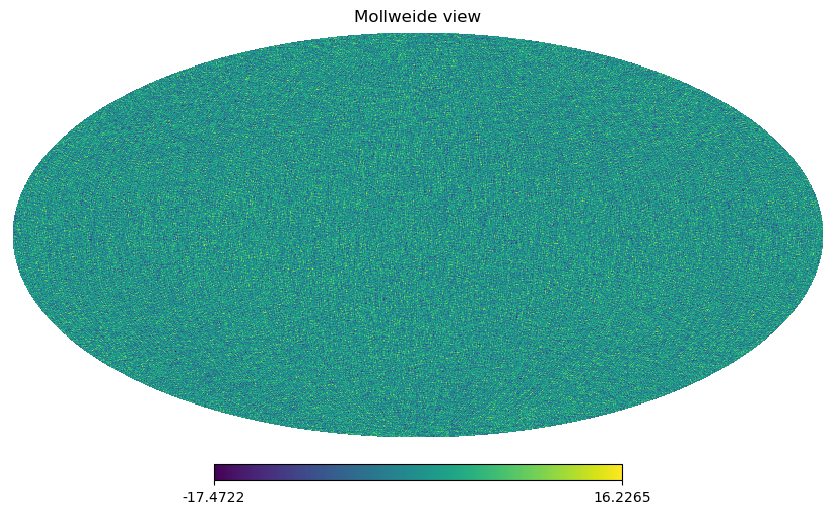

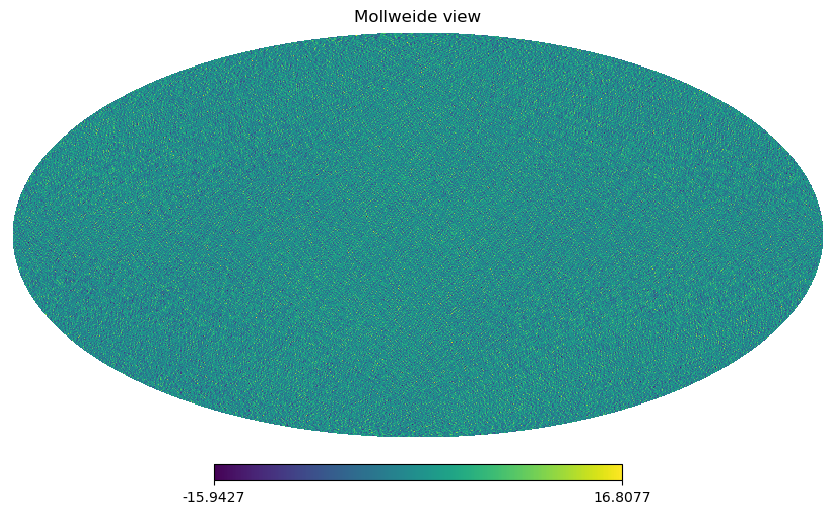

In [5]:
hp.mollview(maps_TQU[0])
hp.mollview(maps_TQU[1])
hp.mollview(maps_TQU[2])

Text(0.5, 1.0, 'U')

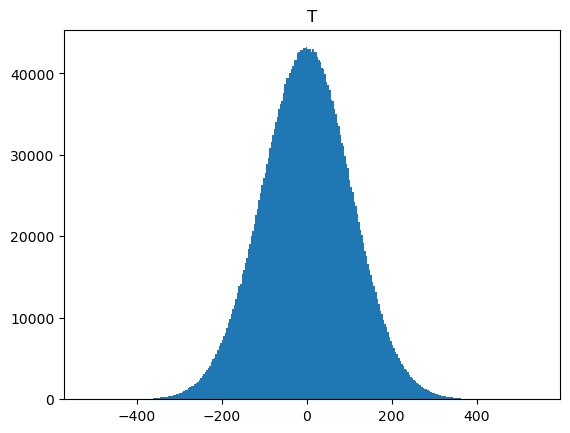

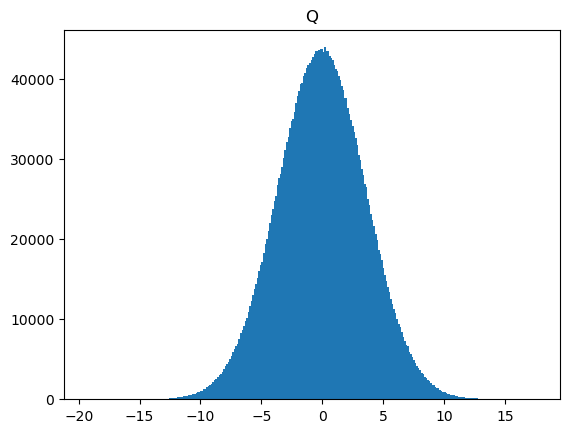

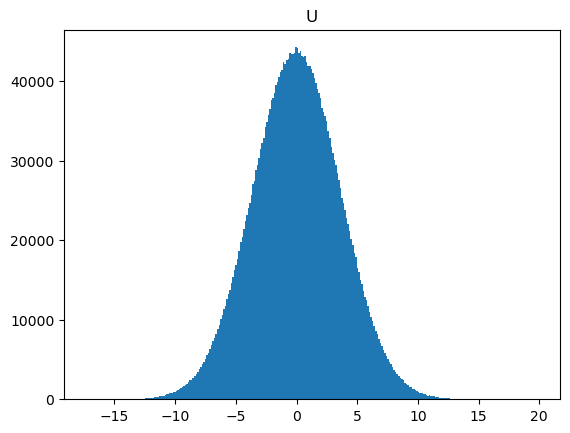

In [6]:
plt.figure()
plt.hist(maps_TQU[0], bins='rice')
plt.title('T')
plt.figure()
plt.hist(maps_TQU[1], bins='rice')
plt.title('Q')
plt.figure()
plt.hist(maps_TQU[2], bins='rice')
plt.title('U')

In [7]:
np.average(maps_TQU[0])

-1.3532450377481964e-05

In [8]:
np.average(maps_TQU[1])

-0.04726309801961542

In [9]:
np.average(maps_TQU[2])

0.0022078588032697836

In [10]:
cls_retrieved = hp.anafast(maps_TQU, lmax=2*nside)

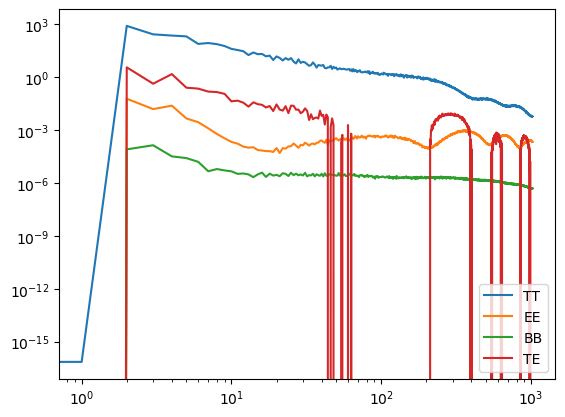

In [11]:
ell_arange = np.arange(cls_retrieved.shape[1])

plt.plot(ell_arange, cls_retrieved.T[:,:4])
plt.loglog()
plt.legend(["TT", "EE", 'BB', 'TE'])
plt.show()

In [12]:
def save_map_Xpure_from_maps(maps_TQU, directory_path='', outname=''):
    """ maps_TQU must have the dimension (3, 12*nside**2)
    """
    print('Shape maps TQU', maps_TQU.shape)
    print('Recording 3-maps in', directory_path, outname)
    map_names = ['T', 'Q', 'U']
    if directory_path=='':
        raise Exception('NO DIRECTORY PATH TO SAVE !!!')
        return
    list_hdu = [fits.PrimaryHDU(maps_TQU)]
    list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=map_names[i], array=maps_TQU[i,:], format='1D') for i in range(3)]))

    hdu_list = fits.HDUList(list_hdu)
    Header = fits.Header()
    endfile = ''
    if outname[-5:] != '.fits':
        endfile = '.fits'
    hdu_list.writeto(directory_path+outname+endfile,overwrite=True)

In [84]:
path_output_map = '/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/'
outname = 'Map_test_band_limited.fits'
save_map_Xpure_from_maps(maps_TQU, directory_path=path_output_map, outname=outname)


Shape maps TQU (3, 3145728)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ Map_test_band_limited.fits


In [13]:
def save_fits_file_from_array(array_to_save, name_column_array, directory_path='', outname=''):
    """ Save arrays with corresponding name_column_array in directory_path+outname
        Note that the first index of the array_to_save will correspond to the number of columns recorded in the fits file

        To save c_ells, the array_to_save should be a vector in 1 dimension
        name_column_array must be a list of the name of the array, even if there is only 1 array
    """
    
    print('Shape array', array_to_save.shape)
    print('Recording 3-maps in', directory_path, outname)
    if directory_path=='':
        raise Exception('NO DIRECTORY PATH GIVEN TO SAVE FITS FILE !')
    
    dimension_array = array_to_save.shape[0]

    list_hdu = [fits.PrimaryHDU(array_to_save)]
    if len(array_to_save.shape) == 1:
        list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=name_column_array[0], array=array_to_save, format='1D')]))
    else :
        list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=name_column_array[i], array=array_to_save[i,:], format='1D') for i in range(dimension_array)]))

    hdu_list = fits.HDUList(list_hdu)
    # Header = fits.Header()


    if directory_path[-1] != '/':
        directory_path += '/'
    endfile = ''
    if outname[-5:] != '.fits':
        endfile = '.fits'
    hdu_list.writeto(directory_path+outname+endfile,overwrite=True)


In [92]:
save_fits_file_from_array(np.ravel(camb_cls[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_1024')
camb_cls_woTE = np.zeros_like(camb_cls)
camb_cls_woTE[:,:3] = camb_cls[:,:3]
save_fits_file_from_array(np.ravel(camb_cls_woTE[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_1024_woTE')
camb_cls_woTE[:,0] = 0
save_fits_file_from_array(np.ravel(camb_cls_woTE[1:,:].T, order='C'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_1024_woTTTE')

Shape array (4096,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_1024
Shape array (4096,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_1024_woTE
Shape array (4096,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_1024_woTTTE


In [ ]:
path_output_map = '/global/homes/m/mag/perl_midapack/midapack/mappraiser/test_wiener_filter/'
outname = 'Map_test_band_limited_woTTTE.fits'
maps_TQU_woTTTE = hp.synfast(camb_cls_woTE.T,nside, new=True)
save_map_Xpure_from_maps(maps_TQU_woTTTE, directory_path=path_output_map, outname=outname)


In [101]:
dir_path = '/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/map_files/'
path_output_filtered_maps = '/global/cscratch1/sd/mag/WF_work/WF_Tests/mapfile_filtered_{}.fits'
path_output_filtered_maps = '/global/cscratch1/sd/mag/WF_work/WF_Tests/mapfile_filtered_bis_{}.fits'
path_output_filtered_maps = '/global/cscratch1/sd/mag/WF_work/WF_Tests/mapfile_filtered_wpow_{}.fits'
path_output_filtered_maps = dir_path + 'mapfile_filtered_wonest_{}.fits'
path_output_filtered_maps = dir_path + 'mapfile_filtered_wonest_sq_{}.fits'
path_output_filtered_maps = dir_path + 'mapfile_filtered_wonest_unit_{}.fits'
path_output_filtered_maps = dir_path + 'mapfile_filtered_wonest_woTT_woTE_{}.fits'
path_output_filtered_maps = dir_path + 'mapfile_filtered_wonest_woTT_woTE_b_{}.fits'

new_dir_path = '/pscratch/sd/m/mag/WF_work/map_files_test_WF/'
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver0_{}.fits'
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_unit_{}.fits'
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_unit2_{}.fits'
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_unit3_{}.fits'
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_unit5_{}.fits'
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_unit6_{}.fits'
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver2_{}.fits' # Lower riangular
# path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver3_{}.fits' # Upper riangular
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver4_{}.fits' # Upper riangular

path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver5_{}.fits' # Upper riangular
path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver6_{}.fits' # Lower riangular

path_output_filtered_maps = new_dir_path + 'mapfile_filtered_newver_woTTTE_0_{}.fits' # Upper riangular -- wo TT TE



maps_output = np.ones((3,12*nside**2))

for i in range(3):
    maps_output[i] = hp.read_map(path_output_filtered_maps.format(i))

In [102]:
print('input :', maps_TQU[0][:10])
print('output :', maps_output[0][:10])

input : [32.06045829 27.21681538 71.60265645 52.74655352 25.63107549 17.48041052
 14.76239419 45.30955514 99.61407253 85.85583538]
output : [2.79558451e-20 3.14028424e-20 5.41884791e-20 5.96961449e-20
 4.82288012e-20 7.25392678e-20 6.68067446e-20 9.93218832e-20
 1.06002013e-19 6.28793169e-20]


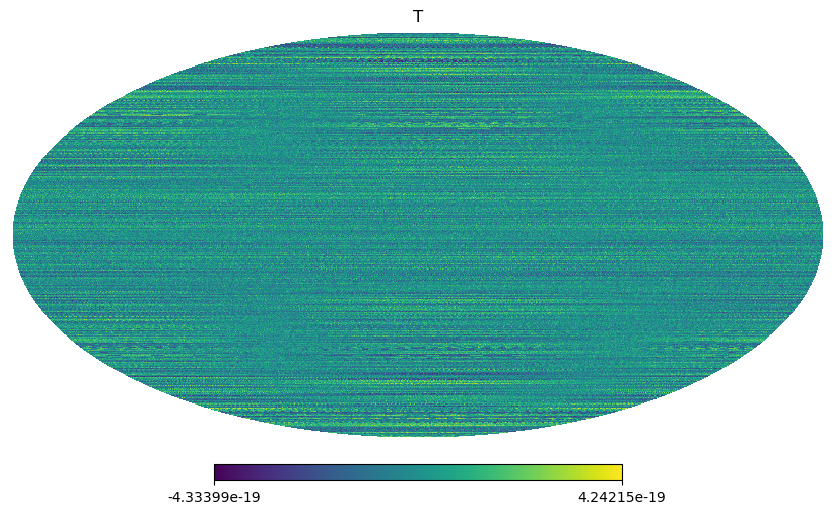

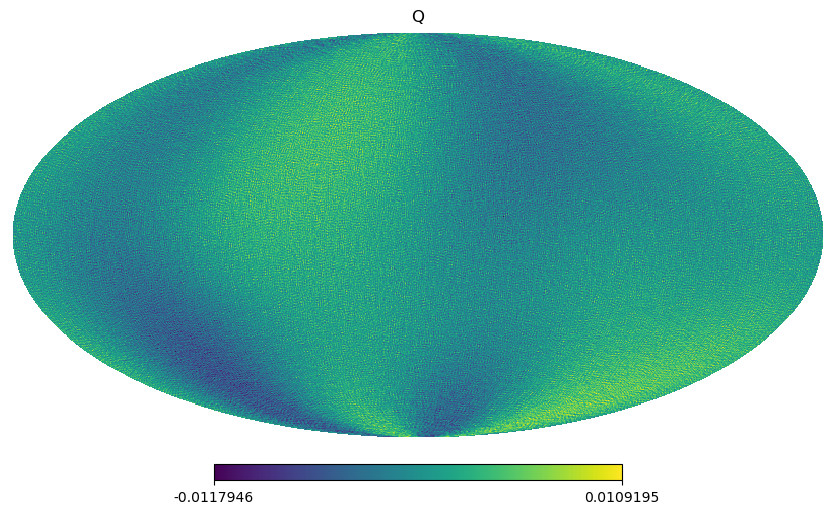

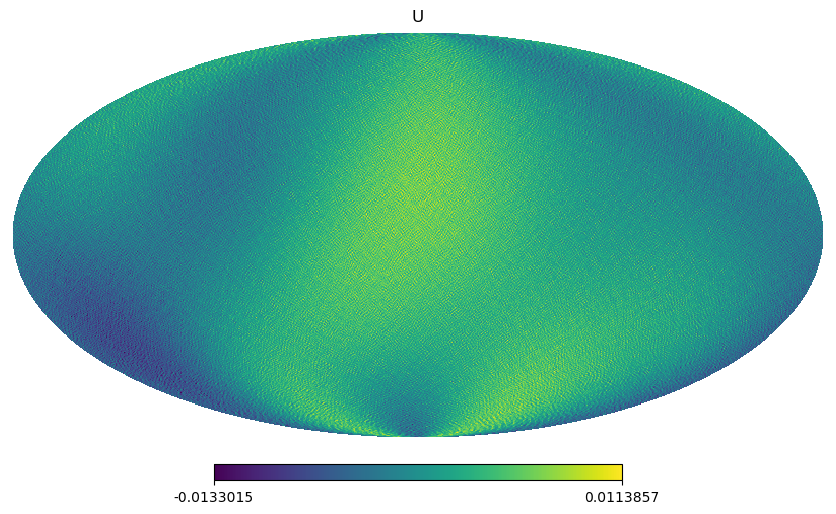

In [103]:
hp.mollview(maps_output[0], title='T')
hp.mollview(maps_output[1], title='Q')
hp.mollview(maps_output[2], title='U')

In [104]:
rms_T = np.sqrt(np.sum(np.power(maps_output[0]-np.mean(maps_output[0]), 2))/len(maps_output[0]))
rms_Q = np.sqrt(np.sum(np.power(maps_output[1]-np.mean(maps_output[2]), 2))/len(maps_output[1]))
rms_U = np.sqrt(np.sum(np.power(maps_output[2]-np.mean(maps_output[2]), 2))/len(maps_output[2]))

Text(0.5, 1.0, 'U : rms = 0.003556781584801225')

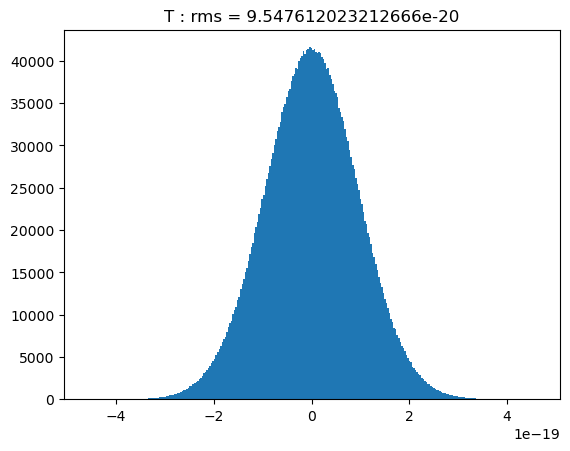

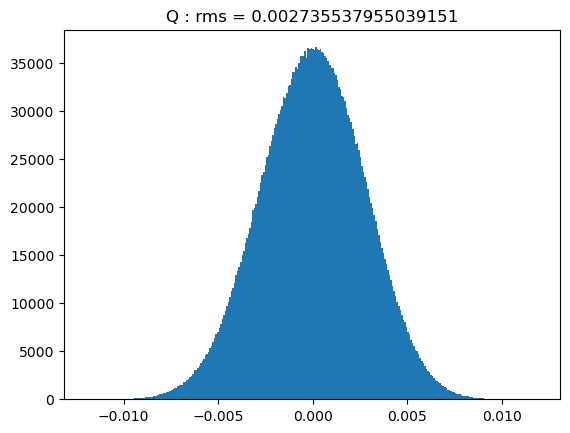

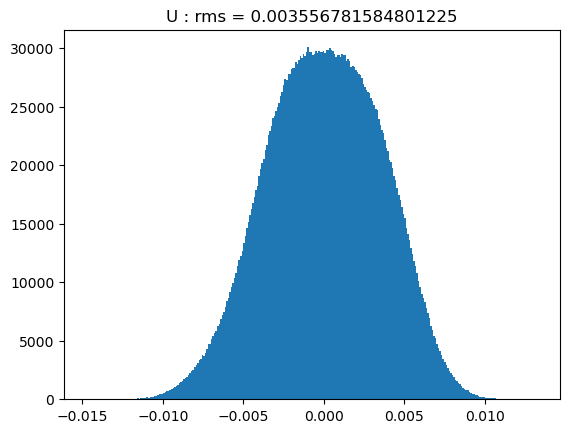

In [105]:
plt.figure()
plt.hist(maps_output[0], bins='rice')
plt.title('T : rms = {}'.format(rms_T))
plt.figure()
plt.hist(maps_output[1], bins='rice')
plt.title('Q : rms = {}'.format(rms_Q))
plt.figure()
plt.hist(maps_output[2], bins='rice')
plt.title('U : rms = {}'.format(rms_U))

In [106]:
c_ells_output = hp.anafast(maps_output, lmax=2*nside)

# maps_output_2 = maps_output.copy()
# maps_output_2[0] = -maps_output_2[0]
# maps_output_2[1] = -maps_output_2[1]
# maps_output_2[2] = -maps_output_2[2]

# c_ells_output = hp.anafast(maps_output_2, lmax=2*nside)

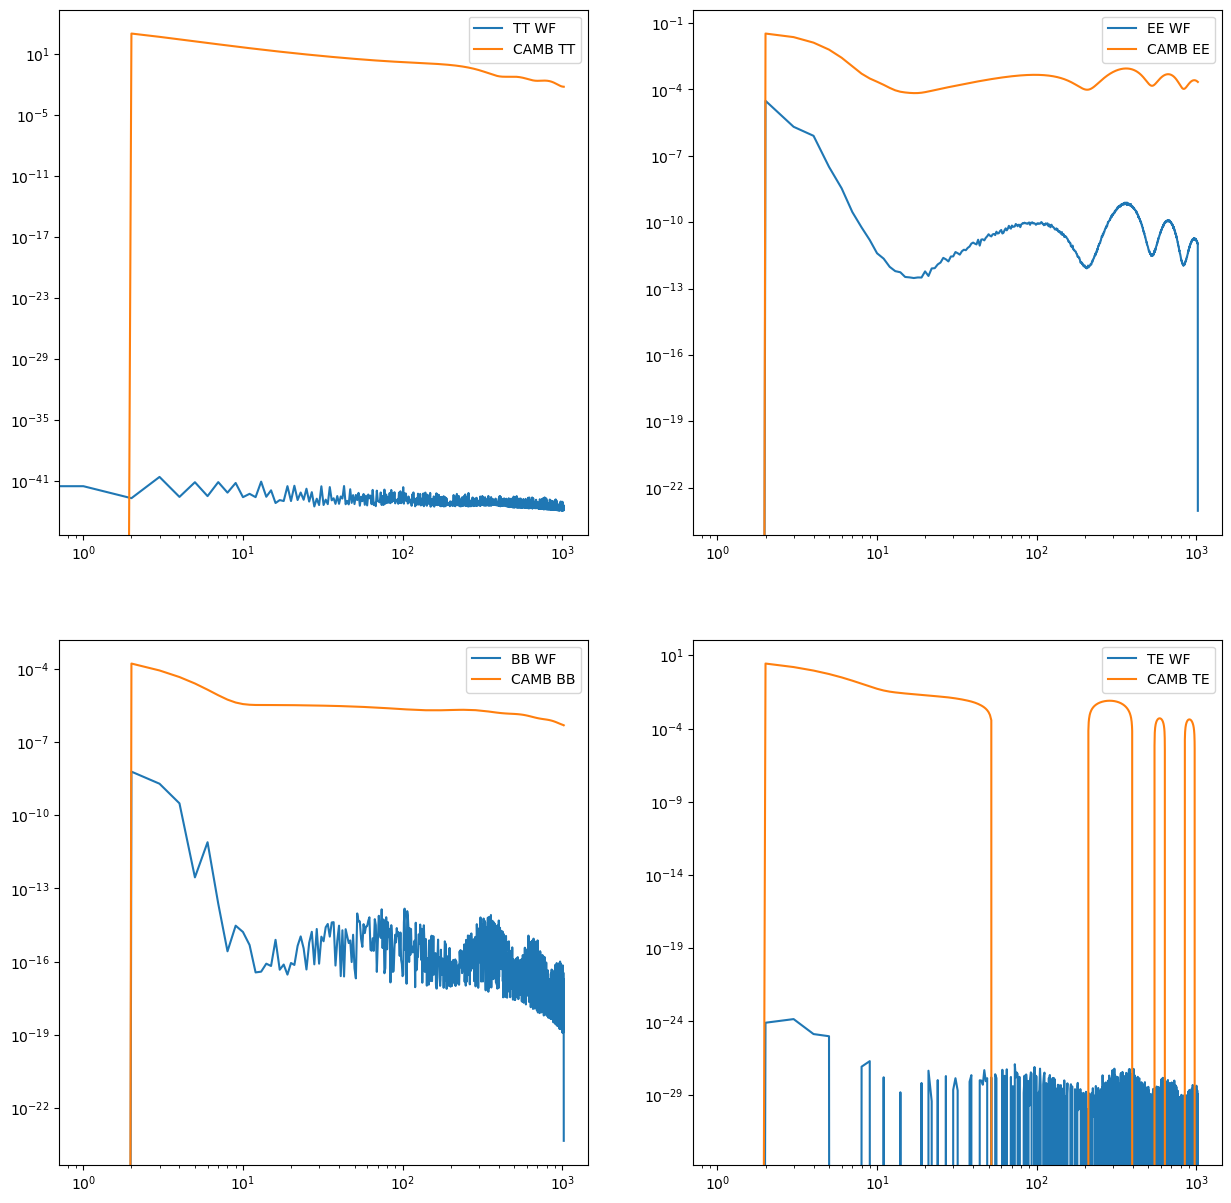

In [107]:
ell_arange = np.arange(c_ells_output.shape[1])
ell_CAMB = np.arange(camb_cls.shape[0])

list_correl = ['TT', 'EE', 'BB', 'TE']

plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(221+i)
    plt.plot(ell_arange, c_ells_output.T[:,i], label='{} WF'.format(list_correl[i]))
    plt.plot(ell_CAMB, camb_cls[:,i], label='CAMB {}'.format(list_correl[i]))
    plt.loglog()
    plt.legend()
plt.show()

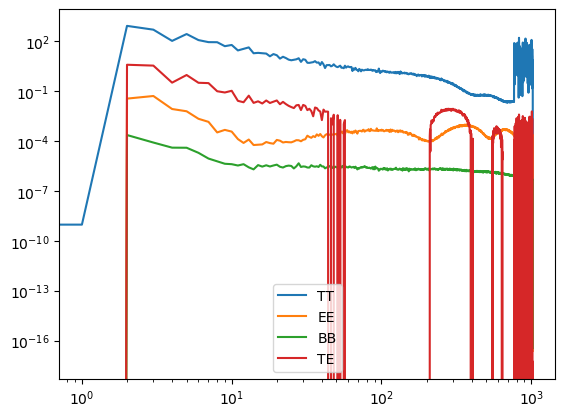

In [55]:
ell_arange = np.arange(c_ells_output.shape[1])

plt.plot(ell_arange, c_ells_output.T[:,:4])
plt.loglog()
plt.legend(["TT", "EE", 'BB', 'TE'])
plt.show()

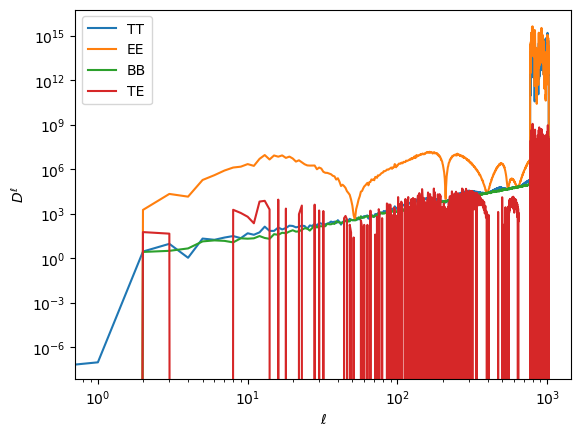

In [22]:
ell_arange = np.arange(c_ells_output.shape[1])

correl_name = ["TT", "EE", 'BB', 'TE']
factor = ell_arange*(ell_arange+1)/(2*np.pi)
for i in range(4):
    plt.plot(ell_arange, factor*c_ells_output.T[:,i], label=correl_name[i])
plt.loglog()
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D^{\ell}$')
plt.show()

In [24]:
c_ells_test = hp.anafast(maps_output[0], lmax=2*nside)

In [25]:
c_ells_test.shape

(1025,)

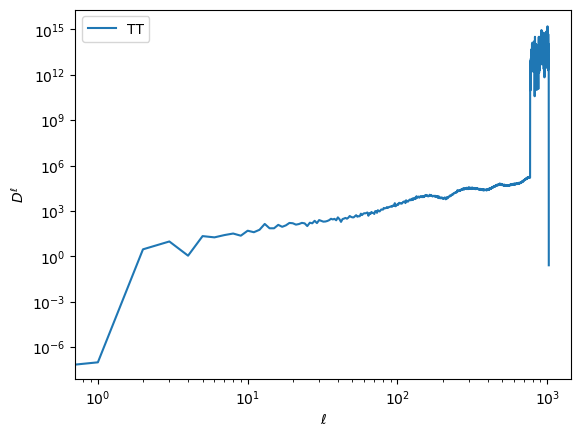

In [26]:
ell_arange_T = np.arange(c_ells_test.shape[0])


factor = ell_arange_T*(ell_arange_T+1)/(2*np.pi)

plt.plot(ell_arange_T, factor*c_ells_test, label='TT')
plt.loglog()
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D^{\ell}$')
plt.show()

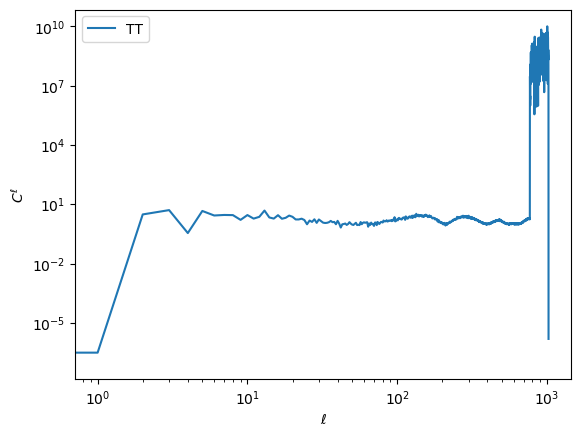

In [27]:
ell_arange_T = np.arange(c_ells_test.shape[0])


factor = ell_arange_T*(ell_arange_T+1)/(2*np.pi)

plt.plot(ell_arange_T, c_ells_test, label='TT')
plt.loglog()
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C^{\ell}$')
plt.show()

In [28]:
alms_Healpy = hp.map2alm(maps_TQU, lmax=2*nside)

In [29]:
alms_Healpy.shape

(3, 525825)

In [30]:
camb_cls.shape

(1025, 4)

In [109]:
lmax = 2*nside
inv_covariance_matrix_woTETT = np.zeros((lmax, 3,3))

for ell in range(2,lmax):
    cov_matrix_woTETT = np.zeros(9)
    cov_matrix_woTETT[0] = camb_cls_woTE[ell,0]
    cov_matrix_woTETT[4] = camb_cls_woTE[ell,1]
    cov_matrix_woTETT[8] = camb_cls_woTE[ell,2]
    cov_matrix_woTETT[1] = camb_cls_woTE[ell,3]
    cov_matrix_woTETT[3] = camb_cls_woTE[ell,3]
    # inv_covariance_matrix[ell] = np.linalg.pinv(cov_matrix.reshape(3,3))
    inv_covariance_matrix_woTETT[ell] = np.linalg.pinv(cov_matrix_woTETT.reshape(3,3))

In [123]:
camb_cls_woTE

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.02199001e+03, 3.35969187e-02, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.91008604e-03, 2.20934233e-04, 0.00000000e+00, 0.00000000e+00],
       [5.90311951e-03, 2.19432405e-04, 0.00000000e+00, 0.00000000e+00],
       [5.89695383e-03, 2.17914688e-04, 0.00000000e+00, 0.00000000e+00]])

In [124]:
test = camb_cls_woTE.ravel('F')
print(test[0], test[1], test[2], test[3], test[1024], test[1025], test[1026])

0.0 0.0 1021.9900118923628 483.7071509323783 0.005896953828991165 0.0 0.0


In [117]:
for ell in range(2,10):
    print(camb_cls_woTE[ell,0], camb_cls_woTE[ell,1], camb_cls_woTE[ell,2], camb_cls_woTE[ell,3])

1021.9900118923628 0.03359691870297146 0.0 0.0
483.7071509323783 0.02315608128510505 0.0 0.0
274.5013456857929 0.013027637334701185 0.0 0.0
175.10680532257444 0.006302294117185589 0.0 0.0
121.17800118202051 0.0027046606697523016 0.0 0.0
89.00006953691134 0.001109326489514659 0.0 0.0
68.32718380551444 0.0005157924401573135 0.0 0.0
54.308079002182154 0.0003124439164257774 0.0 0.0


In [110]:
for ell in range(2,10):
    print(inv_covariance_matrix_woTETT[ell])

[[9.78483144e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.97646343e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[2.06736658e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.31851999e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[3.64296939e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.67598893e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[5.71080032e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.58672379e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[8.25232295e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.69732148e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[1.12359463e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.01447869e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[1.46354634e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93876436e+03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.

In [31]:
lmax = 2*nside
inv_covariance_matrix = np.zeros((lmax, 3,3))

for ell in range(2,lmax):
    cov_matrix = np.zeros(9)
    cov_matrix[0] = camb_cls[ell,0]
    cov_matrix[4] = camb_cls[ell,1]
    cov_matrix[8] = camb_cls[ell,2]
    cov_matrix[1] = camb_cls[ell,3]
    cov_matrix[3] = camb_cls[ell,3]
    # inv_covariance_matrix[ell] = np.linalg.pinv(cov_matrix.reshape(3,3))
    cholesky_decomp = np.linalg.cholesky(np.linalg.inv(cov_matrix.reshape(3,3)))
    cholesky_decomp[0,1] = cholesky_decomp[1,0]
    cholesky_decomp[0,2] = cholesky_decomp[2,0]
    cholesky_decomp[1,2] = cholesky_decomp[2,1]
    inv_covariance_matrix[ell] = cholesky_decomp

In [32]:
lmax = 2*nside
alm_T, alm_E, alm_B = alms_Healpy
alm_T_output, alm_E_output, alm_B_output = np.ones_like(alm_T), np.ones_like(alm_E), np.ones_like(alm_B)
for ell in range(2,lmax):
    min_range = int(ell*(ell+1)/2)
    max_range = int((ell+2)*(ell+1)/2)
    alm_T_output[min_range:max_range+1] = (alm_T[min_range:max_range+1]/inv_covariance_matrix[ell][0,0] + alm_E[min_range:max_range+1]/inv_covariance_matrix[ell][0,1])
    alm_E_output[min_range:max_range+1] = (alm_E[min_range:max_range+1]/inv_covariance_matrix[ell][1,1] + alm_T[min_range:max_range+1]/inv_covariance_matrix[ell][1,0])
    alm_B_output[min_range:max_range+1] = alm_B[min_range:max_range+1]/inv_covariance_matrix[ell][2,2]


In [40]:
lmax = 2*nside
alm_T, alm_E, alm_B = alms_Healpy
alm_T_output, alm_E_output, alm_B_output = np.ones_like(alm_T), np.ones_like(alm_E), np.ones_like(alm_B)
for ell in range(2,lmax):
    min_range = int(ell*(ell+1)/2)
    max_range = int((ell+2)*(ell+1)/2)
    alm_T_output[min_range:max_range+1] = (alm_T[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,0]) + alm_E[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,1]))
    alm_E_output[min_range:max_range+1] = (alm_E[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][1,1]) + alm_T[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][1,0]))
    alm_B_output[min_range:max_range+1] = alm_B[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][2,2])


/tmp/ipykernel_56396/1651361668.py:7: RuntimeWarning: invalid value encountered in sqrt
  alm_T_output[min_range:max_range+1] = (alm_T[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,0]) + alm_E[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,1]))
/tmp/ipykernel_56396/1651361668.py:7: RuntimeWarning: invalid value encountered in divide
  alm_T_output[min_range:max_range+1] = (alm_T[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,0]) + alm_E[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,1]))
/tmp/ipykernel_56396/1651361668.py:8: RuntimeWarning: invalid value encountered in sqrt
  alm_E_output[min_range:max_range+1] = (alm_E[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][1,1]) + alm_T[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][1,0]))
/tmp/ipykernel_56396/1651361668.py:8: RuntimeWarning: invalid value encountered in divide
  alm_E_output[min_range:max_range+1] = (alm_E[min_range:max_range+1]/np.sqrt(inv_covariance

In [33]:
maps_healpy_alms = hp.alm2map((alm_T_output, alm_E_output, alm_B_output), nside=nside)

In [34]:
maps_healpy_alms.shape

(3, 3145728)

In [35]:
cls_healpy_alms = hp.anafast(maps_healpy_alms, lmax=2*nside)


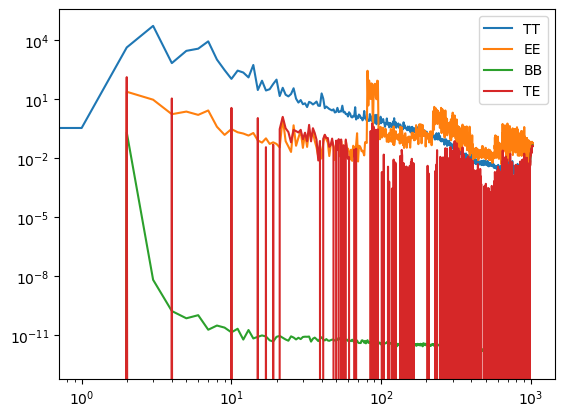

In [36]:
ell_arange = np.arange(cls_healpy_alms.shape[1])

plt.plot(ell_arange, cls_healpy_alms.T[:,:4])
plt.loglog()
plt.legend(["TT", "EE", 'BB', 'TE'])
plt.show()

(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 4.0000e+00, 3.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.00

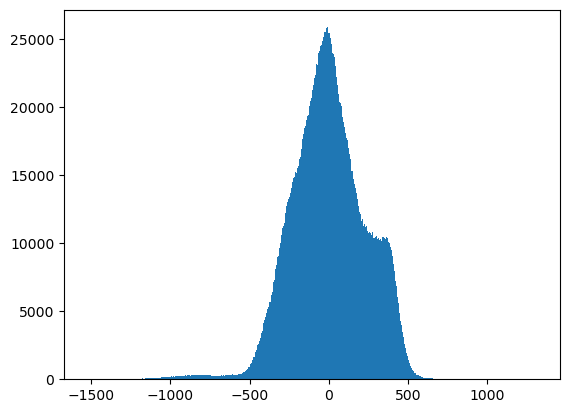

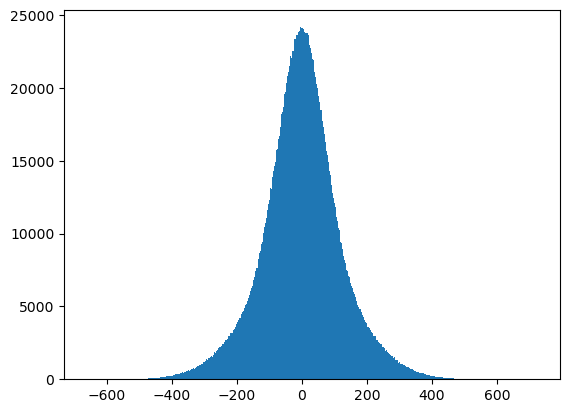

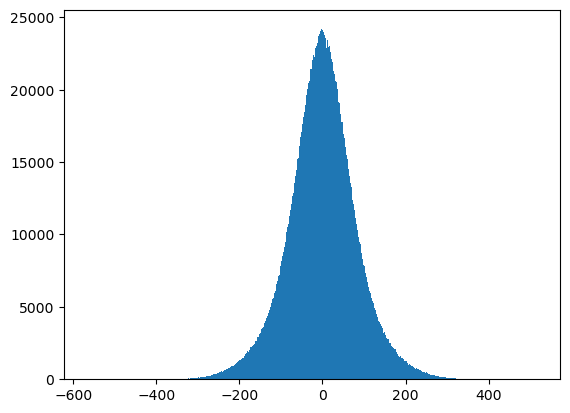

In [37]:
plt.figure()
plt.hist(maps_healpy_alms[0], bins='auto')
plt.figure()
plt.hist(maps_healpy_alms[1], bins='auto')
plt.figure()
plt.hist(maps_healpy_alms[2], bins='auto')